In [1]:
import matplotlib.pyplot as plt

import sys
sys.path.append("../../nansat/")
from nansat import Nansat

sys.path.append("..")
import sar

In [2]:
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt, make_path_filter

local_api = SentinelAPI(None, None, "https://colhub-archive.met.no" ,timeout=180)
api = SentinelAPI(None, None, "https://scihub.copernicus.eu/dhus", timeout=180)

data_dir = "/lustre/storeB/project/IT/geout/machine-ocean/data_raw/sentinel/"

In [3]:
# import dict containing metadata for in-situ data
# https://raw.githubusercontent.com/jerabaul29/MachineOcean_WP1_WHOI/main/mo_whoi_data/data_files/in_situ_dict.py
# from private repo at https://github.com/jerabaul29/MachineOcean_WP1_WHOI
import time
import os

os.environ["TZ"] = "UTC"
time.tzset()

import datetime
import pytz

utc_timezone = pytz.timezone("UTC")

wd = os.getcwd()

os.chdir("../../MachineOcean_WP1_WHOI/mo_whoi_data/data_files")

import in_situ_dict
in_situ_obs = in_situ_dict.get_in_situ_metadata()

os.chdir(wd)

print(in_situ_obs.keys())

dict_keys(['Endurance_8', 'Irminger_7', 'SPURS2', 'Endurance_4', 'Irminger_6', 'Pioneer_5', 'CLIMODE', 'Endurance_9', 'Pioneer_10', 'SouthernOcean2', 'Endurance_3', 'Pioneer_3', 'SPURS1', 'Endurance_7', 'Irminger_3', 'Pioneer_7', 'Pioneer_6', 'Pioneer_8'])


In [4]:
in_situ_obs['Pioneer_7']

{'datetime_start': datetime.datetime(2017, 6, 9, 13, 11, 0, 17529, tzinfo=<UTC>),
 'datetime_end': datetime.datetime(2017, 10, 31, 23, 12, 0, 16778, tzinfo=<UTC>),
 'type': 'whoi_buoy',
 'lat': [40.1334],
 'lon': [-70.7785],
 'nc_data_location': 'received, exported from .mat'}

In [5]:
##### read pickled imported in-situ measurements metadata with attached colocated Sentinel-1 sat products metadata
# (to avoid having to rerun the API search)
import pickle

with open('in_situ_obs.pickle', 'rb') as handle:
    in_situ_obs = pickle.load(handle)

with open('products_scihub.pickle', 'rb') as handle:
    products_scihub = pickle.load(handle)

In [6]:
in_situ_obs.keys()

dict_keys(['Endurance_8', 'Irminger_7', 'SPURS2', 'Endurance_4', 'Irminger_6', 'Pioneer_5', 'CLIMODE', 'Endurance_9', 'Pioneer_10', 'SouthernOcean2', 'Endurance_3', 'Pioneer_3', 'SPURS1', 'Endurance_7', 'Irminger_3', 'Pioneer_7', 'Pioneer_6', 'Pioneer_8'])

# Experiments on Endurance

In [7]:
in_situ_obs['Endurance_3']['products']

OrderedDict([('d995afdb-29f3-406f-a0e8-b2e1cf54e4b0',
              {'title': 'S1A_IW_GRDH_1SDV_20160918T143013_20160918T143038_013108_014CE4_9241',
               'link': "https://scihub.copernicus.eu/dhus/odata/v1/Products('d995afdb-29f3-406f-a0e8-b2e1cf54e4b0')/$value",
               'link_alternative': "https://scihub.copernicus.eu/dhus/odata/v1/Products('d995afdb-29f3-406f-a0e8-b2e1cf54e4b0')/",
               'link_icon': "https://scihub.copernicus.eu/dhus/odata/v1/Products('d995afdb-29f3-406f-a0e8-b2e1cf54e4b0')/Products('Quicklook')/$value",
               'summary': 'Date: 2016-09-18T14:30:13.677Z, Instrument: SAR-C SAR, Mode: VV VH, Satellite: Sentinel-1, Size: 1.58 GB',
               'ondemand': 'false',
               'ingestiondate': datetime.datetime(2016, 9, 18, 17, 15, 47, 684000),
               'beginposition': datetime.datetime(2016, 9, 18, 14, 30, 13, 677000),
               'endposition': datetime.datetime(2016, 9, 18, 14, 30, 38, 676000),
               'mission

In [8]:
fname = 'S1A_IW_GRDH_1SDV_20160918T143013_20160918T143038_013108_014CE4_9241.SAFE'

In [9]:
lat = in_situ_obs['Endurance_3']['lat'][0]
lat

44.6393

In [10]:
lon = in_situ_obs['Endurance_3']['lon'][0]
lon

-124.304

## Load product

In [11]:
n = Nansat(data_dir + fname)

In [12]:
n.get_corners()

(array([-123.73179473, -124.14808758, -126.95166136, -127.28485376]),
 array([45.64333992, 44.14426782, 46.0351342 , 44.53608917]))

## Crop product

## Works but cannot control the corners!

### a)

In [13]:
epsilon = 0.05

In [14]:
extent = sar.crop_sar_data(n, lon, lat, epsilon)

In [15]:
n.get_corners()

(array([-124.22758393, -124.25746094, -124.35029898, -124.37993915]),
 array([44.68568896, 44.57613339, 44.70237624, 44.59282289]))

### Is it inside the lat/lon limits?

### No - corners outside the limits

In [16]:
lonlim=[lon - epsilon, lon + epsilon]
lonlim

[-124.354, -124.254]

In [17]:
latlim=[lat - epsilon, lat + epsilon]
latlim

[44.5893, 44.689299999999996]

In [18]:
lons, lats = n.get_corners()

In [19]:
(min(lons), min(lats), max(lons), max(lats))

(-124.379939147211, 44.57613339386014, -124.2275839327008, 44.70237624339955)

In [20]:
n.get_pixelsize_meters()

(10.16357559530454, 9.969262476095434)

In [21]:
# (x_offset, y_offset, x_size, y_size)

In [22]:
n.crop_lonlat(lonlim=lonlim, latlim=latlim)

(1, 0, 989, 1220)

### b)

In [23]:
epsilon = 0.0005

In [24]:
n = Nansat(data_dir + fname)

In [25]:
sar.crop_sar_data(n, lon, lat, epsilon)

(2271, 11608, 10, 12)

In [26]:
n.get_corners()

(array([-124.30317635, -124.30346907, -124.30441471, -124.3047074 ]),
 array([44.63974379, 44.63866619, 44.63991235, 44.63883475]))

### c)

#### This is the smalles epsilon that works

In [27]:
epsilon = 0.00005

In [28]:
n = Nansat(data_dir + fname)

In [29]:
sar.crop_sar_data(n, lon, lat, epsilon)

(2275, 11614, 1, 1)

In [30]:
n.get_corners()

(array([-124.30381805, -124.30384244, -124.30394188, -124.30396627]),
 array([44.63927241, 44.63918262, 44.63928927, 44.63919947]))

### What if I use another product? Do I get the same corners?

### No - probably because the image is tilted

In [31]:
fname2 = 'S1A_IW_GRDH_1SDV_20160913T142210_20160913T142235_013035_014A71_1F7E.SAFE'

In [32]:
n2 = Nansat(data_dir + fname2)

In [33]:
n2.get_corners()

(array([-121.85589143, -122.26912943, -125.03419407, -125.36737697]),
 array([45.02719571, 43.52801979, 45.41803194, 43.919014  ]))

In [34]:
epsilon = 0.05

In [35]:
sar.crop_sar_data(n2, lon, lat, epsilon)

(17781, 6950, 967, 1211)

In [36]:
n2.get_corners()

(array([-124.23083755, -124.25672235, -124.35123294, -124.37689611]),
 array([44.68652005, 44.57780005, 44.70071553, 44.59199596]))

In [37]:
n2.crop_lonlat(lonlim=lonlim, latlim=latlim)

11:14:58|40|nansat|crop|WARNING! Cropping region is larger or equal to image!


(0, 0, 967, 1211)

## Use sar_params to normalize the images

## Works

In [39]:
epsilon = 0.0005
s0, s0_norm, inc, az, grid_lons, grid_lats, pol = sar.sar_params(
    data_dir + fname,
    station_lon=lon,
    station_lat=lat,
    epsilon=epsilon
)

In [41]:
s0.shape

(12, 10)

In [42]:
s0_norm.shape

(12, 10)

In [44]:
az.shape

(12, 10)

In [46]:
grid_lons.shape

(12, 10)

In [47]:
grid_lats.shape

(12, 10)

In [48]:
pol

'VV'

# Questions

- What is the offset in extent?
- how to use crop_interactive?
- Is it possible to crop using the number of pixels from a certain lat/lon? E.g., 10 pixels in each direction from the center.

# Experiments on Pioneer

In [7]:
in_situ_obs['Pioneer_7'].keys()

dict_keys(['datetime_start', 'datetime_end', 'type', 'lat', 'lon', 'nc_data_location', 'products'])

In [8]:
in_situ_obs['Pioneer_7']['products']

OrderedDict([('7e1d1641-af53-4486-bb45-8411c61d1aba',
              {'title': 'S1A_IW_GRDH_1SDV_20171022T224224_20171022T224249_018932_01FFE8_5D27',
               'link': "https://scihub.copernicus.eu/dhus/odata/v1/Products('7e1d1641-af53-4486-bb45-8411c61d1aba')/$value",
               'link_alternative': "https://scihub.copernicus.eu/dhus/odata/v1/Products('7e1d1641-af53-4486-bb45-8411c61d1aba')/",
               'link_icon': "https://scihub.copernicus.eu/dhus/odata/v1/Products('7e1d1641-af53-4486-bb45-8411c61d1aba')/Products('Quicklook')/$value",
               'summary': 'Date: 2017-10-22T22:42:24.875Z, Instrument: SAR-C SAR, Mode: VV VH, Satellite: Sentinel-1, Size: 1.61 GB',
               'ondemand': 'false',
               'ingestiondate': datetime.datetime(2017, 10, 23, 5, 16, 24, 259000),
               'beginposition': datetime.datetime(2017, 10, 22, 22, 42, 24, 875000),
               'endposition': datetime.datetime(2017, 10, 22, 22, 42, 49, 874000),
               'missi

In [9]:
# (might have to compile some code in Nansat, see warning when importing from nansat)
# (in nansat root dir: python setup.py build_ext --inplace)

# Install nansat dependency (not found in conda env production-10-2022)
#%pip install --user pythesint

# if you are running on you own laptop you will also need to do:
#!sudo apt-get install libgdal-dev
#!pip install --user GDAL==$(gdal-config --version | awk -F'[.]' '{print $1"."$2}')

# list a SAR product with Nansat
n = Nansat(data_dir + "S1A_IW_GRDH_1SDV_20171022T224224_20171022T224249_018932_01FFE8_5D27.SAFE")
print(n)



----------------------------------------
/lustre/storeB/project/IT/geout/machine-ocean/data_raw/sentinel/S1A_IW_GRDH_1SDV_20171022T224224_20171022T224249_018932_01FFE8_5D27.SAFE----------------------------------------
Mapper: sentinel1_l1Band : 1 DN_VH
  dataType: 2
  name: DN_VH
  SourceBand: 1
  SourceFilename: /lustre/storeB/project/IT/geout/machine-ocean/data_raw/sentinel/S1A_IW_GRDH_1SDV_20171022T224224_20171022T224249_018932_01FFE8_5D27.SAFE/measurement/s1a-iw-grd-vh-20171022t224224-20171022t224249-018932-01ffe8-002.tiff
Band : 2 DN_VV
  dataType: 2
  name: DN_VV
  SourceBand: 1
  SourceFilename: /lustre/storeB/project/IT/geout/machine-ocean/data_raw/sentinel/S1A_IW_GRDH_1SDV_20171022T224224_20171022T224249_018932_01FFE8_5D27.SAFE/measurement/s1a-iw-grd-vv-20171022t224224-20171022t224249-018932-01ffe8-001.tiff
Band : 3 sigmaNought_VH
  dataType: 7
  name: sigmaNought_VH
  SourceBand: 1
  SourceFilename: /vsimem/YKVGZCXVNO.vrt
Band : 4 noise_VH
  dataType: 7
  name: noise_VH
  Sou

Variable           Type              Data/Info
----------------------------------------------
Nansat             type              <class 'nansat.nansat.Nansat'>
SentinelAPI        type              <class 'sentinelsat.sentinel.SentinelAPI'>
api                SentinelAPI       <sentinelsat.sentinel.Sen<...>object at 0x1524e21a3610>
b1                 ndarray           16701x25911: 432739611 elems, type `uint16`, 865479222 bytes (825.3853054046631 Mb)
data_dir           str               /lustre/storeB/project/IT<...>-ocean/data_raw/sentinel/
datetime           module            <module 'datetime' from '<...>b/python3.9/datetime.py'>
geojson_to_wkt     function          <function geojson_to_wkt at 0x1524b0211f70>
handle             BufferedReader    <_io.BufferedReader name=<...>'products_scihub.pickle'>
in_situ_dict       module            <module 'in_situ_dict' fr<...>a_files/in_situ_dict.py'>
in_situ_obs        dict              n=18
local_api          SentinelAPI       <sentinelsat

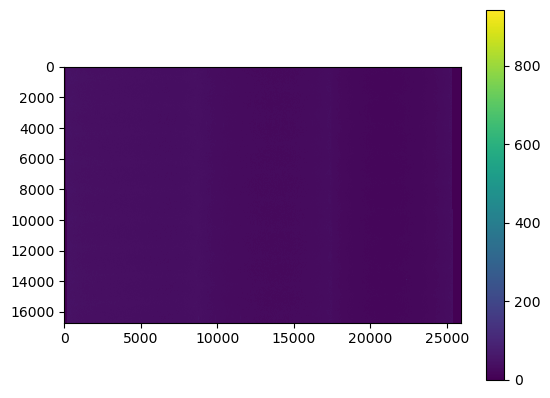

In [10]:
%matplotlib inline
# plot a SAR product with Nansat
b1 = n[1]

%whos
plt.imshow(b1);plt.colorbar()
plt.show()

# write to file
#n.write_figure('map.png', pltshow=True)

In [11]:
b1.max()

942

In [12]:
#extent = n.crop_lonlat(lonlim=[-70.77,-70.78], latlim=[40.13,40.14]) 
epsilon =  0.0005
n.crop_lonlat(lonlim=[-70.7785 - epsilon, -70.7785 + epsilon], latlim=[40.1334 - epsilon, 40.1334 + epsilon])
n
#'lat': [40.1334],
#'lon': [-70.7785]

----------------------------------------
/lustre/storeB/project/IT/geout/machine-ocean/data_raw/sentinel/S1A_IW_GRDH_1SDV_20171022T224224_20171022T224249_018932_01FFE8_5D27.SAFE----------------------------------------
Mapper: sentinel1_l1Band : 1 DN_VH
  dataType: 2
  name: DN_VH
  SourceBand: 1
  SourceFilename: /vsimem/QVLBT755VU.vrt
Band : 2 DN_VV
  dataType: 2
  name: DN_VV
  SourceBand: 2
  SourceFilename: /vsimem/QVLBT755VU.vrt
Band : 3 sigmaNought_VH
  dataType: 7
  name: sigmaNought_VH
  SourceBand: 3
  SourceFilename: /vsimem/QVLBT755VU.vrt
Band : 4 noise_VH
  dataType: 7
  name: noise_VH
  SourceBand: 4
  SourceFilename: /vsimem/QVLBT755VU.vrt
Band : 5 sigmaNought_VV
  dataType: 7
  name: sigmaNought_VV
  SourceBand: 5
  SourceFilename: /vsimem/QVLBT755VU.vrt
Band : 6 noise_VV
  dataType: 7
  name: noise_VV
  SourceBand: 6
  SourceFilename: /vsimem/QVLBT755VU.vrt
Band : 7 look_direction
  colormap: jet
  dataType: 6
  long_name: Sensor Azimuth Angle
  minmax: 0 360
  name: lo

In [13]:
try:
    band_no = n.get_band_number({
        'standard_name': 'surface_backwards_scattering_coefficient_of_radar_wave',
        'polarization': 'HH',
        'dataType': '6',})
except ValueError:
    band_no = n.get_band_number({
        'standard_name': 'surface_backwards_scattering_coefficient_of_radar_wave',
        'polarization': 'VV',
        'dataType': '6',})
pol = n.get_metadata(key='polarization', band_id=band_no)
pol

'VV'

In [14]:
# Get NRCS, incidence angle, and sensor azimuth angle
s0 = n[band_no]
inc = n['incidence_angle']
az = n['look_direction']

# Test the normalization function with different crop sizes

In [15]:
station_lon = -70.7785
station_lat = 40.1334

## epsilon = 0.00005

In [16]:
%%time

# plot a normalize SAR product

# this is VERY memory consuming. I ran this on PPI with: qlogin -q bigmem-r8.q -pe mpi 32
# bigmem-r8.q queue is pretty busy... this may also run with: qlogin -q research-r8.q (but I have not tested it.. might have to tune mem)

s0, s0_norm, inc, az, grid_lons, grid_lats, pol = sar.sar_params(
    data_dir + "S1A_IW_GRDH_1SDV_20171022T224224_20171022T224249_018932_01FFE8_5D27.SAFE",
    station_lon=station_lon,
    station_lat=station_lat,
    epsilon=0.00005
)

CPU times: user 513 ms, sys: 30.3 ms, total: 543 ms
Wall time: 563 ms


In [17]:
s0

array([[-31.700638]], dtype=float32)

## epsilon = 0.0005

In [18]:
%%time

sys.path.append("..")
import sar

# plot a normalize SAR product

# this is VERY memory consuming. I ran this on PPI with: qlogin -q bigmem-r8.q -pe mpi 32
# bigmem-r8.q queue is pretty busy... this may also run with: qlogin -q research-r8.q (but I have not tested it.. might have to tune mem)

s0, s0_norm, inc, az, grid_lons, grid_lats, pol = sar.sar_params(
    data_dir + "S1A_IW_GRDH_1SDV_20171022T224224_20171022T224249_018932_01FFE8_5D27.SAFE",
    station_lon=station_lon,
    station_lat=station_lat,
    epsilon=0.0005
)

CPU times: user 558 ms, sys: 11.2 ms, total: 569 ms
Wall time: 586 ms


In [19]:
s0

array([[-27.61842 , -28.778214, -29.647482, -27.987953, -29.64739 ,
        -32.94355 , -37.160572, -33.638702, -30.6133  , -30.116785],
       [-27.263847, -27.263802, -27.263754, -27.618284, -27.263662,
        -26.279257, -26.922903, -29.647253, -30.6133  , -31.139833],
       [-30.117197, -27.988043, -30.117104, -31.140108, -25.680037,
        -23.626745, -24.592793, -27.618101, -27.618055, -26.922768],
       [-29.647575, -28.374147, -30.117104, -28.374054, -27.618237,
        -26.595142, -27.263569, -27.618101, -25.395046, -24.340874],
       [-29.202045, -28.778214, -27.263754, -26.595232, -29.201862,
        -32.94355 , -31.139969, -27.263525, -25.97432 , -26.279072],
       [-31.70082 , -34.394745, -30.117104, -28.778122, -28.374008,
        -32.299854, -32.943504, -27.263525, -27.987724, -31.700409],
       [-28.374193, -30.613623, -30.613575, -31.140108, -31.700638,
        -31.700592, -29.20177 , -26.595049, -26.922813, -29.647161],
       [-30.117197, -29.202002, -31.14015

In [20]:
lon.shape

NameError: name 'lon' is not defined

In [ ]:
import numpy as np

# Find index of pixel at desired location (input longitude and latitude variables)
y_idx = []
x_idx = []

# something like this?? or do we need something more accurate? 
abslat = np.abs(lat-station_lat)
abslon = np.abs(lon-station_lon)
cor = np.maximum(abslon, abslat)
([y_idx], [x_idx]) = np.where(cor == np.min(cor))

In [ ]:
y_idx

In [ ]:
x_idx

In [ ]:
s0[x_idx, y_idx]

## epsilon = 0.005

In [29]:
%%time

sys.path.append("..")
import sar

# plot a normalize SAR product

# this is VERY memory consuming. I ran this on PPI with: qlogin -q bigmem-r8.q -pe mpi 32
# bigmem-r8.q queue is pretty busy... this may also run with: qlogin -q research-r8.q (but I have not tested it.. might have to tune mem)

s0, s0_norm, inc, az, grid_lons, grid_lats, pol = sar.sar_params(
    data_dir + "S1A_IW_GRDH_1SDV_20171022T224224_20171022T224249_018932_01FFE8_5D27.SAFE",
    station_lon=station_lon,
    station_lat=station_lat,
    epsilon=0.005
)

CPU times: user 637 ms, sys: 14.8 ms, total: 652 ms
Wall time: 742 ms


In [30]:
s0.shape

(122, 103)

In [31]:
lon.shape

(12, 10)

In [32]:
import numpy as np

# Find index of pixel at desired location (input longitude and latitude variables)
y_idx = []
x_idx = []

# something like this?? or do we need something more accurate? 
abslat = np.abs(lat-station_lat)
abslon = np.abs(lon-station_lon)
cor = np.maximum(abslon, abslat)
([y_idx], [x_idx]) = np.where(cor == np.min(cor))

In [33]:
station_lat

40.1334

In [34]:
grid_lats[x_idx, y_idx]

40.1276512729377

In [35]:
grid_lats[x_idx, y_idx+1]

40.12766611488924

In [36]:
station_lon

-70.7785

In [37]:
s0[x_idx, y_idx]

-30.119076

### Check neighbour values

The differences in the locations are very small, but the values change a lot

In [38]:
s0[x_idx-1, y_idx]

-28.78014

In [39]:
s0[x_idx-1, y_idx-1]

-27.265774

In [40]:
s0[x_idx-1, y_idx+1]

-28.376026

In [41]:
s0[x_idx+1, y_idx]

-29.649452

In [42]:
s0[x_idx+1, y_idx-1]

-28.37612

In [43]:
s0[x_idx+1, y_idx +1]

-32.301918

In [44]:
s0[x_idx, y_idx -1]

-28.37612

In [45]:
s0[x_idx, y_idx +1]

-29.649408

## epsilon = 0.05

In [46]:
%%time

sys.path.append("..")
import sar

# plot a normalize SAR product

# this is VERY memory consuming. I ran this on PPI with: qlogin -q bigmem-r8.q -pe mpi 32
# bigmem-r8.q queue is pretty busy... this may also run with: qlogin -q research-r8.q (but I have not tested it.. might have to tune mem)

s0, s0_norm, inc, az, grid_lons, grid_lats, pol = sar.sar_params(
    data_dir + "S1A_IW_GRDH_1SDV_20171022T224224_20171022T224249_018932_01FFE8_5D27.SAFE",
    station_lon=station_lon,
    station_lat=station_lat,
    epsilon=0.05
)

CPU times: user 1.9 s, sys: 160 ms, total: 2.06 s
Wall time: 2.35 s


In [47]:
s0.shape

(1220, 1026)

In [48]:
grid_lons.shape

(1220, 1026)

In [49]:
import numpy as np

# Find index of pixel at desired location (input longitude and latitude variables)
y_idx = []
x_idx = []

# something like this?? or do we need something more accurate? 
abslat = np.abs(lat-station_lat)
abslon = np.abs(lon-station_lon)
cor = np.maximum(abslon, abslat)
([y_idx], [x_idx]) = np.where(cor == np.min(cor))

In [50]:
station_lat

40.1334

In [51]:
grid_lats[x_idx, y_idx]

40.071427915548064

In [52]:
grid_lats[x_idx, y_idx+1]

40.071442811908796

In [53]:
station_lon

-70.7785

In [54]:
s0[x_idx, y_idx]

-25.418646

### We see that the the latitudes are different when we use different epsilon.
### Therefore, we need to use another distance function

## Use another distance function

In [21]:
x_idx, y_idx = sar.get_idx_of_station_in_cropped_image(grid_lons, grid_lats, station_lat, station_lon)

In [22]:
x_idx

6

In [23]:
y_idx

5

In [24]:
grid_lats[x_idx, y_idx]

40.133368062625294

In [25]:
grid_lons[x_idx, y_idx]

-70.77847875460428

In [26]:
s0[x_idx, y_idx]

-31.700592

# Fill in in_situ_obs dict with SAR data

In [7]:
with open(data_dir + 'in_situ_obs_with_sar_params.pickle', 'rb') as handle:
    in_situ_obs = pickle.load(handle)

In [8]:
in_situ_obs.keys()

dict_keys(['Endurance_8', 'Irminger_7', 'SPURS2', 'Endurance_4', 'Irminger_6', 'Pioneer_5', 'CLIMODE', 'Endurance_9', 'Pioneer_10', 'SouthernOcean2', 'Endurance_3', 'Pioneer_3', 'SPURS1', 'Endurance_7', 'Irminger_3', 'Pioneer_7', 'Pioneer_6', 'Pioneer_8'])

In [9]:
in_situ_obs['Irminger_7']['products']['600bc942-80f1-43e1-83e0-c4397a8b5891'].keys()

dict_keys(['title', 'link', 'link_alternative', 'link_icon', 'summary', 'ondemand', 'beginposition', 'endposition', 'ingestiondate', 'missiondatatakeid', 'slicenumber', 'orbitnumber', 'lastorbitnumber', 'relativeorbitnumber', 'lastrelativeorbitnumber', 'filename', 'format', 'identifier', 'size', 'status', 'timeliness', 'sensoroperationalmode', 'swathidentifier', 'orbitdirection', 'producttype', 'platformname', 'platformidentifier', 'instrumentname', 'instrumentshortname', 'productclass', 'polarisationmode', 'acquisitiontype', 'gmlfootprint', 'footprint', 'uuid', 'sar_params'])

In [ ]:
#crop_size = [0.00005]
crop_size = [5e-4, 1e-4, 5e-3, 1e-3, 5e-2]
#count = 0
for buoy in in_situ_obs.keys():
    station_lat = in_situ_obs[buoy]['lat'][0]
    station_lon = in_situ_obs[buoy]['lon'][0]
    print(buoy)
    for product in in_situ_obs[buoy]['products']:
        fname = in_situ_obs[buoy]['products'][product]['filename']
        #count = count + 1
        
        if 'sar_params' not in in_situ_obs[buoy]['products'][product]:
            in_situ_obs[buoy]['products'][product]['sar_params'] = {}
        
        for epsilon in crop_size:
            if str(epsilon) not in in_situ_obs[buoy]['products'][product]['sar_params'] :
                try:
                    s0, s0_norm, inc, az, grid_lons, grid_lats, pol = sar.sar_params(
                        data_dir + fname,
                        station_lon=station_lon,
                        station_lat=station_lat,
                        epsilon=epsilon
                    )

                    epsilon_param_dict = {
                        'epsilon' : epsilon,
                        's0' : s0, 
                        's0_norm' : s0_norm,
                        'inc' : inc,
                        'az' : az,
                        'grid_lons' : grid_lons,
                        'grid_lats' : grid_lats,
                        'pol' : pol
                    }

                    in_situ_obs[buoy]['products'][product]['sar_params'][str(epsilon)] = epsilon_param_dict
                except:
                    print('Buoy ', buoy, 'File ', fname, ' cannot be normalized for epsilon = ', epsilon) # Check if the image exists and if the crop area is within the image
                    #count = count - 1

Endurance_8
Irminger_7
Buoy  Irminger_7 File  S1A_EW_GRDM_1SDH_20210729T200350_20210729T200450_038997_0499E6_20BC.SAFE  cannot be normalized for epsilon =  0.0001 .
Buoy  Irminger_7 File  S1B_EW_GRDM_1SDH_20210728T201123_20210728T201223_027999_03571C_4E75.SAFE  cannot be normalized for epsilon =  0.0001 .
Buoy  Irminger_7 File  S1B_EW_GRDM_1SDH_20210726T202749_20210726T202849_027970_03564C_53AE.SAFE  cannot be normalized for epsilon =  0.0001 .


/home/paulinast/repos/github/machine-ocean-satdata/notebooks/../sar.py:164: RuntimeWarning: divide by zero encountered in log10
  s0 = 10.*np.log10(s0)


Buoy  Irminger_7 File  S1B_EW_GRDM_1SDH_20210723T200308_20210723T200408_027926_03550D_CDDD.SAFE  cannot be normalized for epsilon =  0.0001 .
Buoy  Irminger_7 File  S1A_EW_GRDM_1SDH_20210722T201204_20210722T201304_038895_0496E9_F2E3.SAFE  cannot be normalized for epsilon =  0.0001 .
Buoy  Irminger_7 File  S1B_EW_GRDM_1SDH_20210721T201934_20210721T202034_027897_035427_E8BD.SAFE  cannot be normalized for epsilon =  0.0001 .
Buoy  Irminger_7 File  S1A_EW_GRDM_1SDH_20210717T200350_20210717T200450_038822_0494B4_47AD.SAFE  cannot be normalized for epsilon =  0.0001 .
Buoy  Irminger_7 File  S1B_EW_GRDM_1SDH_20210716T201122_20210716T201222_027824_0351F8_8F78.SAFE  cannot be normalized for epsilon =  0.0001 .
Buoy  Irminger_7 File  S1B_EW_GRDM_1SDH_20210714T202748_20210714T202848_027795_03511D_3CC4.SAFE  cannot be normalized for epsilon =  0.0001 .
Buoy  Irminger_7 File  S1B_EW_GRDM_1SDH_20210711T200307_20210711T200407_027751_034FDC_F105.SAFE  cannot be normalized for epsilon =  0.0001 .
Buoy  

In [ ]:
count

with open(data_dir + 'in_situ_obs_with_sar_params.pickle', 'wb') as handle:
    pickle.dump(in_situ_obs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [67]:
in_situ_obs[buoy]['products'][product]['sar_params'][str(epsilon)]['s0'].mean()

-23.36604

In [18]:
in_situ_obs['Irminger_3']['products']['ac7398fb-855a-4d9c-8975-6eb9698062e7']

{'title': 'S1B_EW_GRDM_1SDH_20170720T084730_20170720T084830_006569_00B8D6_F92F',
 'link': "https://scihub.copernicus.eu/dhus/odata/v1/Products('ac7398fb-855a-4d9c-8975-6eb9698062e7')/$value",
 'link_alternative': "https://scihub.copernicus.eu/dhus/odata/v1/Products('ac7398fb-855a-4d9c-8975-6eb9698062e7')/",
 'link_icon': "https://scihub.copernicus.eu/dhus/odata/v1/Products('ac7398fb-855a-4d9c-8975-6eb9698062e7')/Products('Quicklook')/$value",
 'summary': 'Date: 2017-07-20T08:47:30.151Z, Instrument: SAR-C SAR, Mode: HH HV, Satellite: Sentinel-1, Size: 414.92 MB',
 'ondemand': 'false',
 'ingestiondate': datetime.datetime(2017, 7, 20, 11, 50, 11, 970000),
 'beginposition': datetime.datetime(2017, 7, 20, 8, 47, 30, 151000),
 'endposition': datetime.datetime(2017, 7, 20, 8, 48, 30, 144000),
 'missiondatatakeid': 47318,
 'orbitnumber': 6569,
 'lastorbitnumber': 6569,
 'relativeorbitnumber': 68,
 'lastrelativeorbitnumber': 68,
 'slicenumber': 9,
 'acquisitiontype': 'NOMINAL',
 'filename': 'S1

In [19]:
fname = in_situ_obs['Irminger_3']['products']['ac7398fb-855a-4d9c-8975-6eb9698062e7']['filename']

In [21]:
fname

'S1B_EW_GRDM_1SDH_20170720T084730_20170720T084830_006569_00B8D6_F92F.SAFE'

In [22]:
import os
os.path.exists(data_dir + 'S1B_EW_GRDM_1SDH_20161120T090355_20161120T090455_003040_0052B3_FD0E.zip')

False

In [122]:
n = Nansat(data_dir +fname)
n

02:06:49|40|nansat|_get_dataset_metadata|GDAL could not open /lustre/storeB/project/IT/geout/machine-ocean/data_raw/sentinel/S1B_EW_GRDM_1SDH_20170720T084730_20170720T084830_006569_00B8D6_F92F.SAFE, trying to read with Nansat mappers...


OSError: /lustre/storeB/project/IT/geout/machine-ocean/data_raw/sentinel/S1B_EW_GRDM_1SDH_20170720T084730_20170720T084830_006569_00B8D6_F92F.SAFE: File does not exist

In [111]:
lons, lats = n.get_geolocation_grids()

In [95]:
lonlim=[station_lon - epsilon, station_lon + epsilon]
latlim=[station_lat - epsilon, station_lat + epsilon]

In [96]:
lonlim

[-39.47383, -39.473729999999996]

In [97]:
latlim

[59.93365, 59.93375]

In [112]:
n.crop_lonlat(lonlim=lonlim, latlim=latlim)

RuntimeError: Invalid dataset dimensions : 0 x 10004

with open(data_dir + 'in_situ_obs_with_sar_params.pickle', 'wb') as handle:
    pickle.dump(in_situ_obs, handle, protocol=pickle.HIGHEST_PROTOCOL)
